<a href="https://colab.research.google.com/github/hideaki-kyutech/softcomp2024/blob/main/knapsack_ga_intuitive_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

In [ ]:
from itertools import compress

In [ ]:
import copy
import matplotlib.pyplot as plt

## Individual

In [ ]:
class Item:

    def __init__(self, name, weight, price) -> None:
        self.name = name
        self.weight = weight
        self.price = price


class Individual:
    counter = 0

    @classmethod
    def set_items(cls, items):
        cls.items = items

    @classmethod
    def set_max_weight(cls, max_weight):
        cls.max_weight = max_weight

    @classmethod
    def create_random(cls):
        return Individual([random.choice([0, 1]) for _ in range(len(cls.items))])

    def __init__(self, gene_list) -> None:
        self.gene_list = gene_list
        self.fitness = self.fitness_function()
        self.__class__.counter += 1

    def total_price(self):
        return sum([i.price for i in list(compress(self.__class__.items, self.gene_list))])

    def total_weight(self):
        return sum([i.weight for i in list(compress(self.__class__.items, self.gene_list))])

    def fitness_function(self):
        if self.total_weight() > self.__class__.max_weight:
            return 0
        else:
            return self.total_price()

    def __str__(self):
        return f'gene: {self.gene_list}, price: {self.total_price()}, weight: {self.total_weight()}'

    def plot_info(self):
        print(f'Included: {[i.name for i in list(compress(self.__class__.items, self.gene_list))]}')
        print(f'Fitness: {self.fitness}')
        print(f'Price: {self.total_price()}')
        print(f'Weight: {self.total_weight()}')


## GA Tools

In [ ]:
def selection_rank_with_elite(individuals, elite_size = 0):
    sorted_individuals = sorted(individuals, key = lambda ind: ind.fitness, reverse = True)
    rank_distance = 1 / len(individuals)
    ranks = [(1 - i * rank_distance) for i in range(len(individuals))]
    ranks_sum = sum(ranks)
    selected = sorted_individuals[0:elite_size]

    for i in range(len(sorted_individuals) - elite_size):
        shave = random.random() * ranks_sum
        rank_sum = 0
        for i in range(len(sorted_individuals)):
            rank_sum += ranks[i]
            if rank_sum > shave:
                selected.append(sorted_individuals[i])
                break

    return selected


def crossover_one_point(p1, p2):
    point = random.randint(1, len(p1) - 1)
    c1, c2 = copy.deepcopy(p1), copy.deepcopy(p2)
    c1[point:], c2[point:] = p2[point:], p1[point:]
    return [c1, c2]


def crossover_fitness_driven_one_point(p1, p2):
    point = random.randint(1, len(p1.gene_list) - 1)
    c1, c2 = copy.deepcopy(p1.gene_list), copy.deepcopy(p2.gene_list)
    c1[point:], c2[point:] = p2.gene_list[point:], p1.gene_list[point:]
    child1 = Individual(c1)
    child2 = Individual(c2)
    candidates = [child1, child2, p1, p2]

    best = sorted(candidates, key = lambda ind: ind.fitness, reverse = True)

    return best[0:2]


def mutation_bit_flip(ind):
    mut = copy.deepcopy(ind)
    pos = random.randint(0, len(ind) - 1)
    g1 = mut[pos]
    mut[pos] = (g1 + 1) % 2
    return mut


def mutation_fitness_driven_bit_flip(ind, max_tries = 3):
    for t in range(0, max_tries):
        mut = copy.deepcopy(ind.gene_list)
        pos = random.randint(0, len(ind.gene_list) - 1)
        g1 = mut[pos]
        mut[pos] = (g1 + 1) % 2
        mutated = Individual(mut)
        if mutated.fitness > ind.fitness:
            return mutated
    return ind


def get_items_from_my_room():
    return [
        Item('laptop', 3, 300),
        Item('book', 2, 15),
        Item('radio', 1, 30),
        Item('tv', 6, 230),
        Item('potato', 5, 7),
        Item('brick', 3, 1),
        Item('bottle', 1, 2),
        Item('camera', 0.5, 280),
        Item('smartphone', 0.1, 500),
        Item('picture', 1, 170),
        Item('flower', 2, 5),
        Item('chair', 3, 4),
        Item('watch', 0.05, 500),
        Item('boots', 1.5, 30),
        Item('radiator', 5, 25),
        Item('tablet', 0.5, 450),
        Item('printer', 4.5, 170)
    ]


def crossover_operation(population, method, prob):
    crossed_offspring = []
    for ind1, ind2 in zip(population[::2], population[1::2]):
        if random.random() < prob:
            kid1, kid2 = method(ind1, ind2)
            crossed_offspring.append(kid1)
            crossed_offspring.append(kid2)
        else:
            crossed_offspring.append(ind1)
            crossed_offspring.append(ind2)
    return crossed_offspring


def mutation_operation(population, method, prob):
    mutated_offspring = []
    for mutant in population:
        if random.random() < prob:
            new_mutant = method(mutant)
            mutated_offspring.append(new_mutant)
        else:
            mutated_offspring.append(mutant)
    return mutated_offspring


def plot_stats(fit_avg, fit_best_ever, title):
    plt.plot(fit_avg, label = "Average Fitness of Gen")
    plt.plot(fit_best_ever, label = "Best Fitness")
    plt.title(title)
    plt.legend(loc = "lower right")
    plt.show()


def stats(population, best_ind, fit_avg, fit_best, fit_best_ever):
    best_of_generation = max(population, key = lambda ind: ind.fitness)
    if best_ind.fitness < best_of_generation.fitness:
        best_ind = best_of_generation
    fit_avg.append(sum([ind.fitness for ind in population]) / len(population))
    fit_best.append(best_of_generation.fitness)
    fit_best_ever.append(max(fit_best + fit_best_ever))

    return best_ind, fit_avg, fit_best, fit_best_ever

In [ ]:
def crossover(parent1, parent2):
    child1_genes, child2_genes = crossover_one_point(parent1.gene_list, parent2.gene_list)
    return Individual(child1_genes), Individual(child2_genes)


def mutate(ind):
    mutated_gene = mutation_bit_flip(ind.gene_list)
    return Individual(mutated_gene)

In [ ]:
Individual.set_items(get_items_from_my_room())
Individual.set_max_weight(10)

In [ ]:
random.seed(63)
POPULATION_SIZE = 8
CROSSOVER_PROBABILITY = .7
MUTATION_PROBABILITY = .2
MAX_GENERATIONS = 20

In [ ]:
first_population = [Individual.create_random() for _ in range(POPULATION_SIZE)]
population = first_population.copy()
fitness_list = [ind.fitness for ind in population]
fit_avg = [sum(fitness_list) / len(population)]
fit_best = [max(fitness_list)]
fit_best_ever = [max(fitness_list + fit_best)]
best_ind = random.choice(first_population)
population = first_population.copy()

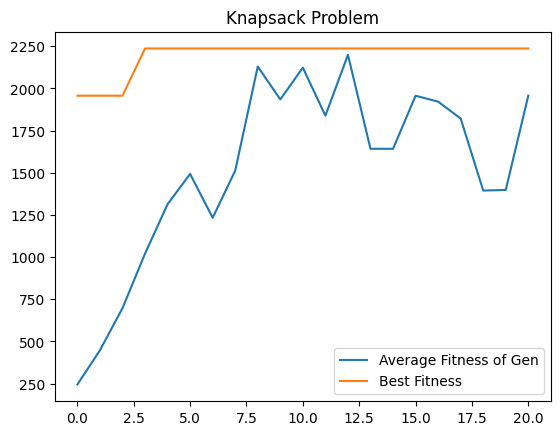

Included: ['laptop', 'radio', 'bottle', 'camera', 'smartphone', 'picture', 'flower', 'watch', 'tablet']
Fitness: 2237
Price: 2237
Weight: 9.15


In [ ]:
generation_number = 0

while generation_number < MAX_GENERATIONS:
    generation_number += 1
    offspring = selection_rank_with_elite(population, elite_size = 2)
    crossed_offspring = crossover_operation(offspring, crossover, CROSSOVER_PROBABILITY)
    mutated_offspring = mutation_operation(crossed_offspring, mutate, MUTATION_PROBABILITY)
    population = mutated_offspring.copy()

    best_ind, fit_avg, fit_best, fit_best_ever = stats(population, best_ind, fit_avg, fit_best, fit_best_ever)

plot_stats(fit_avg, fit_best_ever, "Knapsack Problem")
best_ind.plot_info()